# Mathematical approach to the solution of a 1-D Single phase oil resevoir



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def thomasAlgorithm(n, soe):
    """
    # n is the number of equations
    # soe is the system of equations
    This function takes in a tri-diagonal system of equations, soe and rhe number of the equations, n, as parameters. It employs the thomas algorithm to return the solution of these sytem of equations.
    """
    w = [0]*n
    g = [0]*n
    w[0] = soe[0][1] / soe[0][0]
    g[0] = soe[0][2] / soe[0][0]

    for i in range(1,n-1):
        w[i] = soe[i][2] / (soe[i][1] - (soe[i][0])*w[i-1])
        g[i] = (soe[i][3] - ((soe[i][0])*g[i-1])) / (soe[i][1] - (soe[i][0])*w[i-1])
        
    g[n-1] = (soe[n-1][2] - ((soe[n-1][0])*g[n-2])) / (soe[n-1][1] - (soe[n-1][0])*w[n-2])            
    #back-substitution            
    solution = [0]*n
    solution[n-1] = g[n-1]
    for i in range(n-2, -1, -1):
        solution[i] = g[i] - w[i]*solution[i+1]

    solu = [round(i, 100) for i in solution]
    return solu

In [3]:
#LHS generator
def LHS(n,Ac,Bc):
    """
    This forms the Left Hand Side of the System of Equations, which is mostly constant with Ac and Bc
    """
    lhs = [0]*n
    for i in range(1,n-1):
        lhs[i] = [Ac, -Bc, Ac]
    lhs[0] = [Ac-Bc, Ac]
    lhs[n-1] = [Ac, -Bc+Ac]   
    return lhs


#RHS generator
def RHS(n, Ac, r, solut, prod_blocks):
    """
    This forms the Right Hand Side of the System of Equations, which involves using the pressure values from the previous timestep.
    """
    rhs = [0]*n
    for i in range(n):
        Pi = solut[i]
        rhs[i] = -float(r * Pi)
        if prod_blocks != None:
            if i+1 in prod_blocks:
                q = prod_blocks[i+1]
                rhs[i] = -float((r * Pi) + q)
    return rhs

#equation
def LRHS(n, lhs, rhs):
    """
    This joins the LHS and RHS to form the System of Equations
    """
    for i in range(n):
        lhs[i].append(rhs[i])
    soe = lhs
    return soe

In [4]:
#INPUT
def params():
    property_data = pd.read_csv("savedata/database.csv")
    #check property_data.description for the description of the property variables below(just outside this params() function).
    data = pd.Series(property_data["value"].values, index = property_data["property"].values)
    return data

def fix_values():
    temp = params()
    dt = float(temp.get("dt"))
    dx = float(temp.get("dx"))
    A = float(temp.get("A"))
    k = float(temp.get("k"))
    u = float(temp.get("u"))
    B = float(temp.get("B"))
    ct = float(temp.get("ct"))* (10 ** -6)
    ph = float(temp.get("ph"))
    Pi = float(temp.get("Pi"))
    sim_time  = float(temp.get("sim_time"))
    n = int(temp.get("n"))
    prod_blockss = temp.get("prod_blocks")
    prod_blocks = None

    if prod_blockss == 0:
        prod_blocks = None
    elif prod_blockss != 0:
        prod_blocks = {}
        for j in prod_blockss.split(","):
            temp2 = j.split()
            prod_blocks[int(temp2[0].strip())] = float(temp2[1].strip())
    return [dx, dt, A, k, u, B, ct, ph, Pi, sim_time, n, prod_blocks]

In [5]:
params()

dx                      2000
dt                        10
A                     750000
k                        290
u                          2
B                          1
ct                        35
ph                      0.22
Pi                      6000
sim_time                2000
n                         12
prod_blocks    2 -100, 10 75
dtype: object

In [6]:
#prior calculation
#Vb, r, Ac, Bc are all constants, check procedure of solution for clarity
def calculations():
    temp = fix_values()    
    dx, dt, A, k, u, B, ct, ph, Pi, sim_time, n, prod_blocks = temp
    Vb = float(A * dx)
    r = float((Vb * ph * (ct)) / (5.615 * B * dt))
    Ac = float((1.127 * A * (k/1000)) / (u * B * dx))
    Bc = float((2 * Ac) + r)
    
    rt = int(sim_time / dt)
    pressure_distribution = [0]
    solut = [Pi]*n
    pressure_distribution[0] = solut
    a = 0
    index_names, tstep = [0], 0
    for i in range(rt+1):
        tstep += dt
        index_names.append(tstep)
        lis = pressure_distribution[a]
        lhs = LHS(n, Ac, Bc)
        rhs = RHS(n, Ac, r, lis, prod_blocks)
        soe = LRHS(n, lhs, rhs)
        pressure_distribution.append(thomasAlgorithm(n, soe))
        a =  a + 1
    return [pressure_distribution, index_names, temp]

In [7]:
#convert results to a DataFrame
def to_df():
    pressure_distribution, index_names, temp = calculations()
    dx, dt, A, k, u, B, ct, ph, Pi, sim_time, n, prod_blocks = temp  
    pressure_distribution_dict, block_widths, width = {}, [], dx
    rt = int(sim_time / dt)
    for k in range(n):
        det = "Block " + str(k + 1)
        _ = [i[k] for i in pressure_distribution]
        pressure_distribution_dict[det] = _
        block_widths.append([width for o in range(rt + 2)])
        width += dx    
    
    pressure_dist_df = pd.DataFrame(pressure_distribution_dict,  index = index_names)
    pressure_dist_df.to_excel("savedata/Pressure Distribution.xlsx", sheet_name = "Pressure Distribution", index = True)
    
    return [pressure_dist_df, block_widths, index_names]

In [8]:
#plotting results
def pressure_time():
    """
    pressure against time plot.
    """
    temp = to_df()
    pressure_dist_df, index_names = temp[0], temp[2]
    fig1 = plt.figure(figsize = (7, 9))
    for col in pressure_dist_df.columns:
        plt.plot(index_names, pressure_dist_df[col], label = col)
    plt.xlabel('Time(days)')
    plt.ylabel('Pressure(psi)')
    plt.title('Pressure distribution with time')
    plt.legend()
    plt.savefig("savedata/pressure_time.png", orientation = "portrait", bbox_inches = "tight")
    plt.show()


def pressure_space():
    """
    pressure against space plot.
    """
    temp = to_df()
    pressure_dist_df, block_widths = temp[0], temp[1]
    fig2 = plt.figure(figsize = (7, 9))
    ut = 0
    for col in pressure_dist_df.columns:
        plt.plot(block_widths[ut],pressure_dist_df[col], label = col)
        ut += 1
    plt.xlabel('Block widths(ft)')
    plt.ylabel('Pressure(psi)')
    plt.title('Pressure distribution with space')
    plt.legend()
    plt.savefig("savedata/pressure_space.png", orientation = "portrait", bbox_inches = "tight") 
    plt.show()

In [9]:
#avg. pressure plot
def average_pressure_plot():
    """
    average pressure plot.
    """
    temp = to_df()
    pressure_dist_df, index_names = temp[0], temp[2]
    avgs = pressure_dist_df.mean(axis = 1)
    fig3 = plt.figure(figsize = (7, 9))
    plt.plot(index_names, avgs, label = "Average Pressure across Reservoir")
    plt.xlabel('Time(days)')
    plt.ylabel('Average Reservoir Pressure(psi)')
    plt.title('Average Reservoir Pressure distribution with time')
    plt.legend()
    plt.savefig("savedata/avg_pressure_time.png", orientation = "portrait", bbox_inches = "tight")
    plt.show()


#3D plot
def final_plot():
    """
    3D plot, pressure, time and space.
    """
    pressure_dist_df, block_widths, index_names = to_df()
    newp = pressure_dist_df.transpose()    
    fig = plt.figure(figsize = (8, 10))
    ax = fig.gca(projection = '3d')

    x = np.array([index_names])
    y = np.array(block_widths)
    z = newp.values

    im = ax.plot_surface(x, y, z, cmap = cm.hot)
    plt.colorbar(im, shrink = 0.2, aspect = 10)
    plt.xlabel('Time step(days)')
    plt.ylabel('Blocks(ft)')    
    ax.set_zlabel('Pressure(psi)')
    plt.title('Plot of Pressure against Space and Time.')
    plt.show()
    plt.savefig("savedata/pressure_space_time.png", orientation = "portrait", bbox_inches = "tight")

<IPython.core.display.Javascript object>


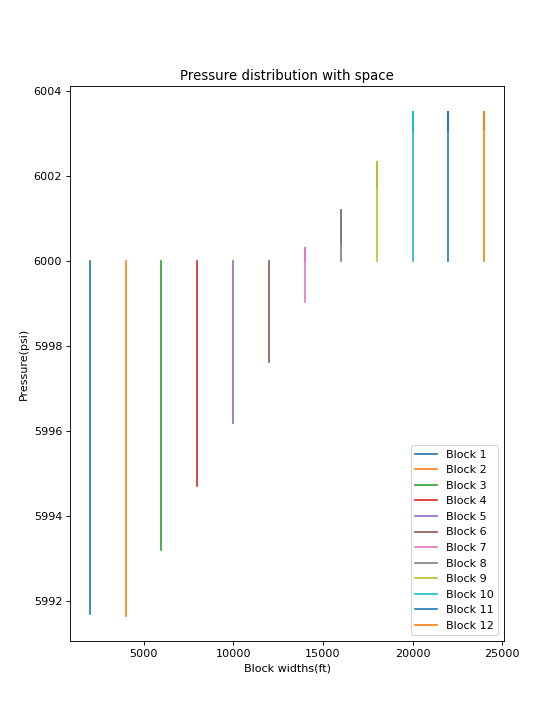

In [10]:
pressure_space()

<IPython.core.display.Javascript object>


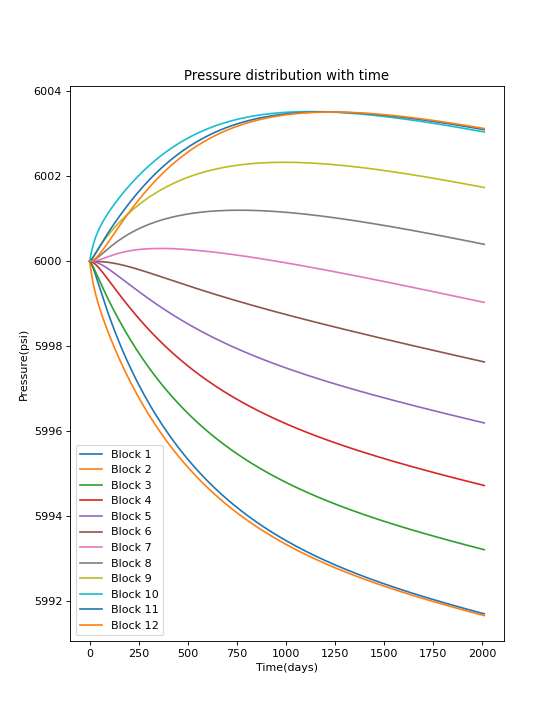

In [11]:
pressure_time()

<IPython.core.display.Javascript object>


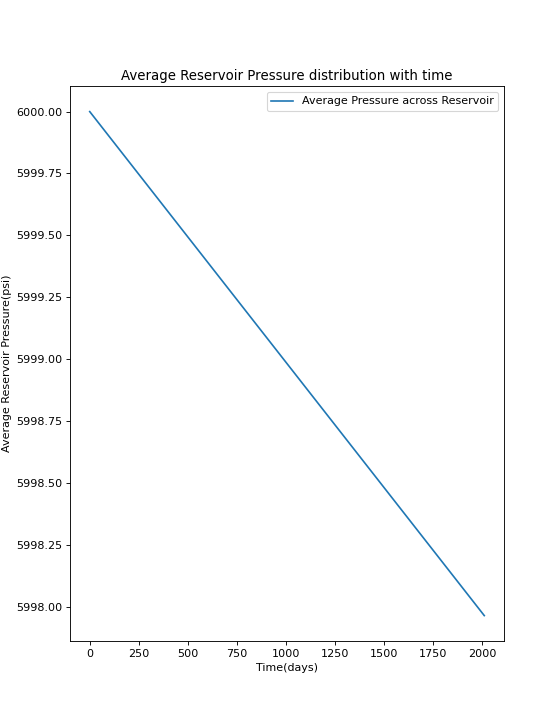

In [12]:
average_pressure_plot()

<IPython.core.display.Javascript object>


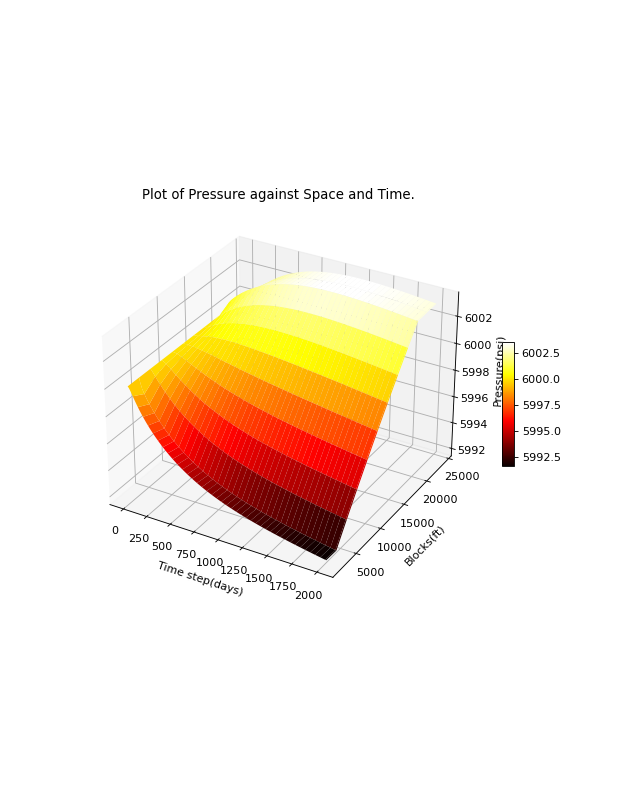

In [13]:
final_plot()